In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams["figure.figsize"] = (8,5)

## Read in ONE-DAY data for ONE ticker

In [3]:
TRADES= "../sample_data/AAPL_trades.csv.gz"
QUOTES="../sample_data/AAPL_quotes.csv.gz"

In [4]:
df_trades = pd.read_csv(Path(TRADES),compression='gzip')
df_quotes = pd.read_csv(Path(QUOTES),compression='gzip')

In [5]:
df_quotes.columns

Index(['Unnamed: 0', 'Time', 'Exchange', 'Symbol', 'Bid_Price', 'Bid_Size',
       'Offer_Price', 'Offer_Size', 'Quote_Condition', 'Sequence_Number',
       'National_BBO_Indicator', 'FINRA_BBO_Indicator',
       'FINRA_ADF_MPID_Indicator', 'Quote_Cancel_Correction',
       'Source_Of_Quote', 'Retail_Interest_Indicator',
       'Short_Sale_Restriction_Indicator', 'LULD_BBO_Indicator',
       'SIP_Generated_Message_Identifier', 'NBBO_LULD_Indicator',
       'Participant_Timestamp', 'FINRA_ADF_Timestamp',
       'FINRA_ADF_Market_Participant_Quote_Indicator',
       'Security_Status_Indicator', 'Date', 'YearMonth'],
      dtype='object')

## EDA & Visualization

In [6]:
df_trades_sample = df_trades.sample(frac=0.1).reset_index(drop=True)
df_quotes_sample = df_quotes.sample(frac=0.1).reset_index(drop=True)

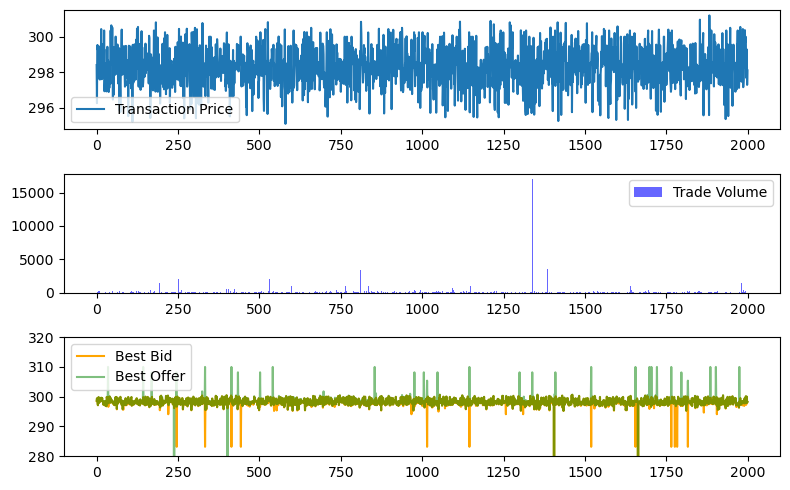

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)
sample_trades = df_trades_sample.iloc[:2000]
sample_quotes = df_quotes_sample.iloc[:2000]
ax1.plot(sample_trades['Trade_Price'], label='Transaction Price')
ax1.legend()
ax2.bar(sample_trades.index, sample_trades['Trade_Volume'], color='b', alpha=0.6, label='Trade Volume')
ax2.legend()
ax3.plot(sample_quotes['Bid_Price'], color='orange', label='Best Bid')
ax3.plot(sample_quotes['Offer_Price'], color='g', alpha=0.5, label='Best Offer')
ax3.set_ylim(280, 320)
ax3.legend()


plt.tight_layout()

## Transform the data
#### Clean & Preprocess the data

In [96]:
class Configuration:
    def __init__(self, trades, quotes):
        self._trades = trades
        self._quotes = quotes
        self._event = None
    
    @classmethod
    def load_data(cls, fp_trade, fp_quote, debug=True):
        df_trades = cls._parse_config_files(fp_trade)
        df_quotes = cls._parse_config_files(fp_quote)
        if debug:
            df_trades = df_trades.sample(frac=0.1).reset_index(drop=True)
            df_quotes = df_quotes.sample(frac=0.1).reset_index(drop=True)
        return cls(
            trades = df_trades,
            quotes = df_quotes
        )
    
    @classmethod
    def _parse_config_files(cls, filepath: str) -> pd.DataFrame:
        return pd.read_csv(Path(filepath),compression='gzip')
    
    
    def preprocess(self, dropAfterHours = False, dropIrregularHours=True):
        self._trades['Participant_Timestamp'] = self._convertParticipantTimestamp(self._trades['Participant_Timestamp'].values, self._trades['Date'].values)
        self._quotes['Participant_Timestamp'] = self._convertParticipantTimestamp(self._quotes['Participant_Timestamp'].values, self._quotes['Date'].values)
        if dropAfterHours:
            self._trades = self._drop_after_hours(self._trades, self._trades['Participant_Timestamp'])
            self._quotes = self._drop_after_hours(self._quotes, self._quotes['Participant_Timestamp'])
        if dropIrregularHours:
            self._trades = self._drop_irreg_hours(self._trades, self._trades['Participant_Timestamp'])
            self._quotes = self._drop_irreg_hours(self._quotes, self._quotes['Participant_Timestamp'])
        return
    
    
    def reconstruct(self, trade_cols, quote_cols) -> pd.DataFrame:

        try:
            self._trades = self._trades.loc[:, trade_cols]
            self._quotes = self._quotes.loc[:, quote_cols]
        except KeyError:
            print ("Invalid Columns")
        
        
        # reconstruct event
        self._reconstruct()

        # compute trade direction
        self._event['Dir'] = self._generate_trade_side(self._event['Trade_Price'].values)

        # assign mox identifiers
        self._event['MOX'] = pd.factorize(self._event['Participant_Timestamp'])[0]
        mox_duplicates = ~self._event.duplicated('MOX', keep='last')
        self._event['Last_Idx'] = np.where(mox_duplicates, self._event.index, np.nan)
        self._event['Last_Idx'] = self._event['Last_Idx'].fillna(method='bfill').astype(int)
        
        # mark valid quotes
        self._event['Valid_Quotes'] = ~self._event[self._event['Is_Quote']==True].duplicated('MOX', keep='last').astype('boolean')
        
        # reduce memory
        self._event = self._reduce_memory_usage(self._event)

        return self._event


    def _reconstruct(self):
        invalid_trades_idx, invalid_quotes_idx = [], []
        # invalid trades
        if "Trade_Price" in self._trades.columns:
            invalid_trades_idx.extend(self._trades[self._trades["Trade_Price"] < 0].index)
        if "Trade_Volume" in self._trades.columns:
            invalid_trades_idx.extend(self._trades[self._trades["Trade_Volume"] < 0].index)
        if "Trade_Reporting_Facility" in self._trades.columns:
            invalid_trades_idx.extend(self._trades[self._trades["Trade_Reporting_Facility"] == "D"].index)
            self._trades.drop("Trade_Reporting_Facility", axis=1, inplace=True)

        self._trades.drop(invalid_trades_idx, inplace=True)
        

        # invalid quotes
        if "Bid_Price" in self._quotes.columns:
            invalid_quotes_idx.extend(self._quotes[self._quotes["Bid_Price"] < 0].index)
        if "Offer_Price" in self._quotes.columns:
            invalid_quotes_idx.extend(self._quotes[self._quotes["Offer_Price"] < self._quotes["Bid_Price"]].index)
        
        self._quotes.drop(invalid_quotes_idx, inplace=True)
        
        self._quotes['Is_Quote'] = True
        self._trades['Is_Quote'] = False
        self._event = pd.concat([self._trades, self._quotes])
        
        self._event.sort_values(by=['Participant_Timestamp'], inplace=True)
        self._event.reset_index(drop=True, inplace=True)
        
        return

    @property
    def trades(self):
        return self._trades
    
    @property
    def quotes(self):
        return self._quotes
    
    @property
    def event(self):
        return self._event

    @staticmethod
    def _convertParticipantTimestamp(pts, date):
        date = pd.to_datetime(date)
        pts = pd.to_datetime(np.char.zfill(pts.astype(str), 15),format="%H%M%S%f")

        return date + pd.to_timedelta(
            pts.hour * 60 * 60 * 1e9 +   # Convert hours to nanoseconds
            pts.minute * 60 * 1e9 +     # Convert minutes to nanoseconds
            pts.second * 1e9 +          # Convert seconds to nanoseconds
            pts.microsecond * 1e3       # Convert microseconds to nanoseconds
        )
    
    @staticmethod
    def _drop_after_hours(df, pts):
        mask = (pts.dt.time < pd.Timestamp("09:00:00").time()) | \
            (pts.dt.time > pd.Timestamp("16:00:00").time())
        drop_idx = df[mask].index
        df = df.drop(drop_idx)
        return df

    @staticmethod
    def _drop_irreg_hours(df, pts):
        mask = (pts.dt.time < pd.Timestamp("09:15:00").time()) | \
            (pts.dt.time > pd.Timestamp("15:45:00").time())
        drop_idx = df[mask].index
        df = df.drop(drop_idx)
        return df

    @staticmethod
    def _generate_trade_side(trade_prices):
        """
        Classify trade side using tick test.
        """
        trade_direction_dic = {
            "uptick": 1,
            "zero-uptick": 1,
            "downtick": -1,
            "zero-downtick": -1,
            "NaN": np.nan
        }
        pre_price, pre_cat = 0, "uptick"
        trade_cats = []
        for p in trade_prices:
            if pd.isna(p):
                trade_cats.append("NaN")
                continue
            else:
                if p > pre_price:
                    trade_cats.append("uptick")
                    pre_cat = "uptick"
                elif p < pre_price:
                    trade_cats.append("downtick")
                    pre_cat = "downtick"
                else:
                    if pre_cat == "downtick":
                        trade_cats.append("zero-downtick")
                        pre_cat = "zero-downtick"
                    elif pre_cat == "uptick":
                        trade_cats.append("zero-uptick")
                        pre_cat = "zero-uptick"
                    else:
                        trade_cats.append(pre_cat)

                pre_price = p

        trade_signs = [trade_direction_dic[c] for c in trade_cats]

        return trade_signs
    
    @staticmethod
    def _reduce_memory_usage(df, verbose=False):
        numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
        start_mem = df.memory_usage().sum() / 1024 ** 2
        for col in df.columns:
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == "int":
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                    ):
                        df[col] = df[col].astype(np.float16)
                    elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                    ):
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        end_mem = df.memory_usage().sum() / 1024 ** 2
        if verbose:
            print(
                "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                    end_mem, 100 * (start_mem - end_mem) / start_mem
                )
            )
        return df


In [97]:
dataWrapper = Configuration.load_data(TRADES, QUOTES, debug=True)
dataWrapper.preprocess()

t_cols = ['Participant_Timestamp', 'Symbol', 'Trade_Id', 'Trade_Price', 'Trade_Volume', 'Trade_Reporting_Facility']
q_cols = ['Participant_Timestamp', 'Symbol', 'Bid_Price', 'Bid_Size', 'Offer_Price', 'Offer_Size']
df = dataWrapper.reconstruct(trade_cols=t_cols, quote_cols=q_cols)

In [98]:
df.dtypes

Participant_Timestamp    datetime64[ns]
Symbol                           object
Trade_Id                        float16
Trade_Price                     float16
Trade_Volume                    float16
Is_Quote                           bool
Bid_Price                       float16
Bid_Size                        float16
Offer_Price                     float16
Offer_Size                      float16
Dir                             float16
MOX                               int32
Last_Idx                          int32
Valid_Quotes                    boolean
dtype: object

#### Feature Generation (Calendar Mode)

In [103]:
class CalendarMode:
    def __init__(self, df, delta1, delta2, start_idx, end_idx) -> None:
        self._df = df
        self.delta1 = delta1
        self.delta2 = delta2
        self.start_idx = start_idx
        self.end_idx = end_idx
    
    @classmethod
    def from_deltas(cls, df, delta1, delta2):
        timestamps = df['Participant_Timestamp'].values
        #'left' return i s.t. a[i-1] < v <= a[i]
        #‘right’ returns i s.t. a[i-1] <= v < a[i]
        start_idx = np.searchsorted(timestamps, timestamps - delta2, side='right')
        end_idx = np.searchsorted(timestamps, timestamps - delta1, side='left')
        end_idx = np.maximum(end_idx, df['Last_Idx'])
        return cls(
            df = df.copy(),
            delta1 = delta1,
            delta2 = delta2,
            start_idx = start_idx,
            end_idx = end_idx
        )
    
    #Breath
    def getBreath(self) -> pd.DataFrame:
        if 'Breath' in self._df.columns:
            return self._df['Breath']
        else:
            self._df['Breath'] = [self._df.iloc[start:end+1]['Is_Quote'].eq(False).sum() \
                                       for start, end in zip(self.start_idx, self.end_idx)]
            return self._df['Breath']
    
    #Immediacy
    def getImmediacy(self) -> pd.Series:
        if 'Immediacy' in self._df.columns:
            return self._df['Immediacy']
        else:
            breath = self.getBreath()
            delta_diff = (self.delta2-self.delta1)/np.timedelta64(1,'s')
            self._df['Immediacy'] = np.where(breath == 0, np.nan, (delta_diff) / breath)
            return self._df['Immediacy']

    #VolumeAll
    def getVolumeAll(self) -> pd.Series:
        if 'VolumeAll' in self._df.columns:
            return self._df['VolumeAll']
        else:
            self._df['VolumeAll'] = [self._df.iloc[start:end+1]['Trade_Volume'].sum() \
                                          for start, end in zip(self.start_idx, self.end_idx)]
            return self._df['VolumeAll']
    
    # VolumeAvg
    def getVolumeAvg(self) -> pd.Series:
        if 'VolumeAvg' in self._df.columns:
            return self._df['VolumeAvg']
        else:
            volumeAll = self.getVolumeAll()
            breath = self.getBreath()
            self._df['VolumeAvg'] = volumeAll/breath
            return self._df['VolumeAvg']
    

    # VolumeMax
    def getVolumeMax(self) -> pd.Series:
        if 'VolumeMax' in self._df.columns:
            return self._df['VolumeMax']
        else:
            self._df['VolumeMax'] = [max(self._df.iloc[start:end+1]['Trade_Volume'], default=0) \
                                          for start, end in zip(self.start_idx, self.end_idx)]
            return self._df['VolumeMax']

    # Lambda
    def getLambda(self) -> pd.Series:
        if 'Lambda' in self._df.columns:
            return self._df['Lambda']
        else:
            volumeAll = self.getVolumeAll()
            p_max = np.array([df.iloc[start:end+1]['Trade_Price'].max() for start, end in zip(self.start_idx, self.end_idx)])
            p_min = np.array([df.iloc[start:end+1]['Trade_Price'].min() for start, end in zip(self.start_idx, self.end_idx)])
            self._df['Lambda'] = np.where(volumeAll != 0, (p_max - p_min) / volumeAll, np.nan)
            return self._df['Lambda']

    # LobImbalance
    def getLobImbalance(self) -> pd.Series:
        if 'LobImbalance' in self._df.columns:
            return self._df['LobImbalance']
        else:
            self._df['Imbalance'] = (self._df['Offer_Size'] - self._df['Bid_Size']) / (self._df['Offer_Size'] + self._df['Bid_Size'])
            self._df['LobImbalance'] = [self._df.iloc[start:end+1]['Imbalance'].mean() for start, end in zip(self.start_idx, self.end_idx)]
            return self._df['LobImbalance']

    # TxnImbalance
    def getTxnImbalance(self) -> pd.Series:
        if 'TxnImbalance' in self._df.columns:
            return self._df['TxnImbalance']
        else:
            volumeAll = self.getVolumeAll()
            self._df['Vt_Dir'] = self._df['Trade_Volume'] * self._df['Dir']
            sum_Vt_Dir = [self._df.iloc[start:end+1]['Vt_Dir'].sum() for start, end in zip(self.start_idx, self.end_idx)]
            self._df['TxnImbalance'] = np.where(volumeAll != 0, sum_Vt_Dir / volumeAll, np.nan)
            return self._df['TxnImbalance']
        
    # PastReturn
    def getPastReturn(self) -> pd.Series:
        if 'PastReturn' in self._df.columns:
            return self._df['PastReturn']
        else:
            p_avg = np.array([df.iloc[start:end+1]['Trade_Price'].mean() for start, end in zip(self.start_idx, self.end_idx)])
            p_max = np.array([df.iloc[start:end+1]['Trade_Price'].max() for start, end in zip(self.start_idx, self.end_idx)])
            self._df['PastReturn'] = 1 - p_avg/p_max
            return self._df['PastReturn']
        
    # Turnover

    # AutoCov

    # QuotedSpread

    # EffectiveSpread

    
    @property
    def dataframe(self):
        return self._df
    
    @property
    def indices(self):
        return pd.DataFrame({
            'Participant_Timestamp': self._df['Participant_Timestamp'],
            'Start': self.start_idx,
            'End': self.end_idx
        })
    
    
   

In [104]:
delta1, delta2 = np.timedelta64(1, 'ns'), np.timedelta64(5, 's')
caln_mode = CalendarMode.from_deltas(df, delta1, delta2)

In [101]:
df.iloc[:10]

,Participant_Timestamp,Symbol,Trade_Id,Trade_Price,Trade_Volume,Is_Quote,Bid_Price,Bid_Size,Offer_Price,Offer_Size,Dir,MOX,Last_Idx,Valid_Quotes
0,2020-01-02 09:15:08.271574,AAPL,NaN,NaN,NaN,True,295.25,3.0,296.75,2.0,NaN,0,0,True
1,2020-01-02 09:15:09.340550,AAPL,1439.0,296.25,50.0,False,NaN,NaN,NaN,NaN,1.0,1,1,<NA>
2,2020-01-02 09:15:09.340712,AAPL,NaN,NaN,NaN,True,295.25,3.0,296.25,2.0,NaN,2,2,True
3,2020-01-02 09:15:09.341636,AAPL,NaN,NaN,NaN,True,283.25,1.0,296.25,2.0,NaN,3,3,True
4,2020-01-02 09:15:14.393411,AAPL,NaN,NaN,NaN,True,296.00,27.0,296.00,1.0,NaN,4,4,True
5,2020-01-02 09:15:14.393854,AAPL,1445.0,296.00,34.0,False,NaN,NaN,NaN,NaN,-1.0,5,6,<NA>
6,2020-01-02 09:15:14.393854,AAPL,NaN,NaN,NaN,True,296.00,27.0,296.25,1.0,NaN,5,6,True
7,2020-01-02 09:15:14.425246,AAPL,NaN,NaN,NaN,True,296.00,1.0,296.25,1.0,NaN,6,7,True
8,2020-01-02 09:15:19.529393,AAPL,NaN,NaN,NaN,True,296.00,2.0,296.25,1.0,NaN,7,8,True
9,2020-01-02 09:15:27.753647,AAPL,NaN,NaN,NaN,True,296.00,1.0,296.25,1.0,NaN,8,9,True


In [43]:
caln_mode.getBreath()

0          0
1          1
2          1
3          1
4          1
          ..
199959    12
199960    12
199961    12
199962    12
199963    12
Name: Breath, Length: 199964, dtype: int64

In [44]:
caln_mode.getVolumeAll()

0            0.0
1          100.0
2          100.0
3          100.0
4           41.0
           ...  
199959    1060.0
199960    1060.0
199961    1060.0
199962    1060.0
199963    1060.0
Name: VolumeAll, Length: 199964, dtype: float16

In [105]:
caln_mode.getPastReturn()

0              NaN
1         0.000000
2         0.000000
3         0.000000
4              NaN
            ...   
200400    0.000834
200401    0.000834
200402    0.000834
200403    0.000834
200404    0.000834
Name: PastReturn, Length: 200405, dtype: float64

## Load the data

In [48]:
# caln_mode.dataframe.to_csv("results.csv")